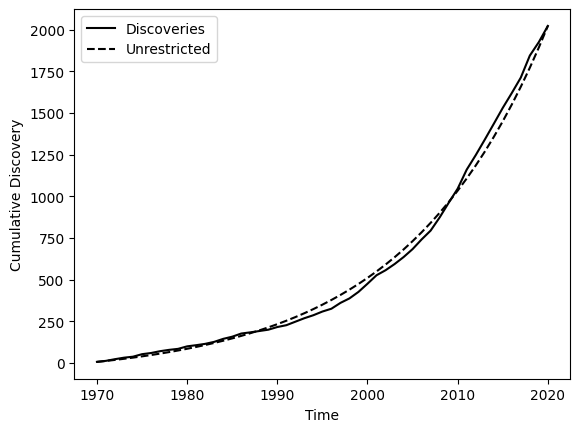

In [ ]:
checklist_path = "/Users/maarten/Documents/GIT/b3alien/tests/data/belgium/dwca-unified-checklist-v1.14/"
distribution = checklist_path + "distribution.txt"

df_cl = pd.read_csv(distribution, sep='\t', low_memory=False)

# Specific issue due to the Belgian checklist
df_cl["speciesKey"] = df_cl["id"].str.rsplit("/", n=1).str[-1].astype("int64")

# 1. Filter rows where locality == 'Belgium' and eventDate is not missing
df = df_cl[df_cl["locality"] == "Belgium"].copy()
df = df[df["eventDate"].notna()]

# 2. Split eventDate into intro and outro (assuming 'YYYY/MM' or 'YYYY/MM/YYYY/MM')
def split_event_date(x):
    if isinstance(x, str):
        parts = x.strip().split('/')
        if len(parts) == 2:
            intro = parts[0]
            outro = parts[1]
        else:
            intro = outro = np.nan
        return pd.Series([intro, outro])
    else:
        return pd.Series([np.nan, np.nan])

df[["introDate", "outroDate"]] = df["eventDate"].apply(split_event_date)

df["introDate"] = pd.to_datetime(df["introDate"], format="%Y", errors="coerce")
df["outroDate"] = pd.to_datetime(df["outroDate"], format="%Y", errors="coerce")


# 3. Clean rows with missing introDate
df_intro = df.dropna(subset=["introDate"]).copy()

# 4. Group by introDate and count species
in_species = (
    df_intro.groupby("introDate", sort=True)["id"]
    .count()
    .reset_index(name="nspec")
)

# 5. Cumulative sum
in_species["cumn"] = in_species["nspec"].cumsum()

# 6. Clean outro side and count outgoing species
df_outro = df.dropna(subset=["outroDate"]).copy()

out_species = (
    df_outro.groupby("outroDate", sort=True)["id"]
    .count()
    .reset_index(name="nspeco")
)

# 7. Merge intro and outro on date
n_species = pd.merge(in_species, out_species, how="outer", left_on="introDate", right_on="outroDate")

# 8. Replace NaNs with 0
n_species["nspec"] = n_species["nspec"].fillna(0).astype(int)
n_species["nspeco"] = n_species["nspeco"].fillna(0).astype(int)

# 9. Net species present at each time step
n_species["total"] = n_species["nspec"] - n_species["nspeco"]

# 10. Final frame with total species over time
tot_species = n_species[["introDate", "total"]].copy()

# 11. Optional: sort and compute cumulative total over time
tot_species = tot_species.sort_values("introDate")
tot_species["cumulative_total"] = tot_species["total"].cumsum()

def filter_time_window(df, start_year, end_year):
    """Filter time and rate based on year window."""
    filtered = df[(df["year"] >= start_year) & (df["year"] <= end_year)].reset_index(drop=True)
    return filtered["year"], filtered["rate"]


in_species["time"] = pd.to_datetime(in_species["introDate"])
in_species["cumulative_species"] = in_species["cumn"]

time, rate = b3cube.calculate_rate(in_species)


df = pd.DataFrame({
    "year": time,
    "rate": rate
})

time, rate = filter_time_window(df, 1970, 2020)

C1, vec1 = simulation.simulate_solow_costello_scipy(time, rate, vis=True)

Bootstrapping: 100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


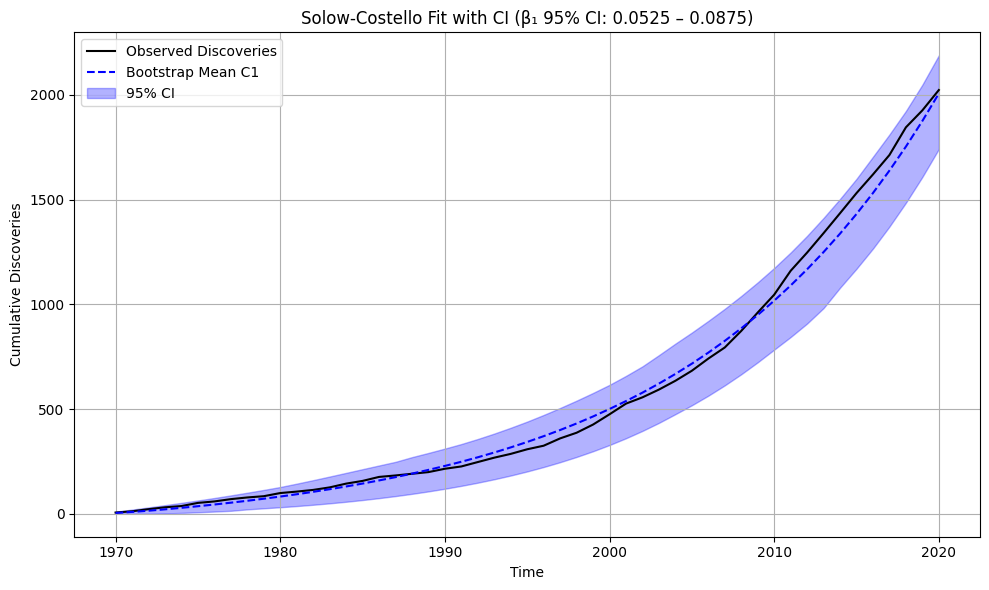

In [ ]:
results = simulation.parallel_bootstrap_solow_costello(time, rate, n_iterations=200)

simulation.plot_with_confidence(time, rate, results)